# Logistic Regression Consulting Project
By **Vivien BOGNE TIENOUE**

## Binary Customer Churn

A marketing agency has many customers that use their service to produce ads for the client/customer websites. They've noticed that they have quite a bit of churn in clients. They basically randomly assign account managers right now, but want you to create a machine learning model that will help predict which customers will churn (stop buying their service) so that they can correctly assign the customers most at risk to churn an account manager. Luckily they have some historical data, can you help them out? Create a classification algorithm that will help classify whether or not a customer churned. Then the company can test this against incoming data for future customers to predict which customers will churn and assign them an account manager.

The data is saved as customer_churn.csv. Here are the fields and their definitions:

    Name : Name of the latest contact at Company
    Age: Customer Age
    Total_Purchase: Total Ads Purchased
    Account_Manager: Binary 0=No manager, 1= Account manager assigned
    Years: Totaly Years as a customer
    Num_sites: Number of websites that use the service.
    Onboard_date: Date that the name of the latest contact was onboarded
    Location: Client HQ Address
    Company: Name of Client Company
    
Once you've created the model and evaluated it, test out the model on some new data (you can think of this almost like a hold-out set) that your client has provided, saved under new_customers.csv. The client wants to know which customers are most likely to churn given this data (they don't have the label yet).

# 1. Review the data


### Importing useful libraries, starting pyspark session and loading the data

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression

In [2]:
spark = SparkSession.builder.appName('logistic_regression_consulting_project').getOrCreate()

In [3]:
data = spark.read.csv("customer_churn.csv", header=True, inferSchema=True)

### Shape of data

In [4]:
data.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [5]:
data.count(), len(data.columns)

(900, 10)

In [6]:
data.schema.names

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn']

### Finding null values 

In [7]:
Null_values = {col:data.filter(data[col].isNull()).count() for col in data.columns}
Null_values

{'Names': 0,
 'Age': 0,
 'Total_Purchase': 0,
 'Account_Manager': 0,
 'Years': 0,
 'Num_Sites': 0,
 'Onboard_date': 0,
 'Location': 0,
 'Company': 0,
 'Churn': 0}

### Finding Duplicate rows

In [8]:

df1=data.groupBy('Names', 'Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Onboard_date', 'Location', 'Company', 'Churn').count().filter("count > 1")

df1.drop('count').show()


+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
|Names|Age|Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date|Location|Company|Churn|
+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+



> The data seems to be clean, there are no null value and also no duplicates ROWS

In [9]:
data.show()

+-------------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|              Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+-------------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|   Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|      Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|        Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|      Phillip White|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|     

# 2.  Data Features

   We have 4 categoricals columns to deal with.
   - The Names of a client,
   - The Onboard_date,
   - The Location,
   - and the company.
   
   More over, we don't know if those columns are relevants for the Churn or not relevant.

### Converting String into numerical with StringIndexer


In [10]:
from pyspark.ml.feature import StringIndexer

categorical_column = ['Names', 'Onboard_date', 'Location', 'Company']
categorical_column_index = ['Names_index', 'Onboard_date_index', 'Location_index', 'Company_index']
indexer = StringIndexer(inputCols= categorical_column, outputCols=categorical_column_index)
indexed = indexer.fit(data).transform(data)
data = indexed


## Let us visualise the data if it is relevant or not to add those categorical

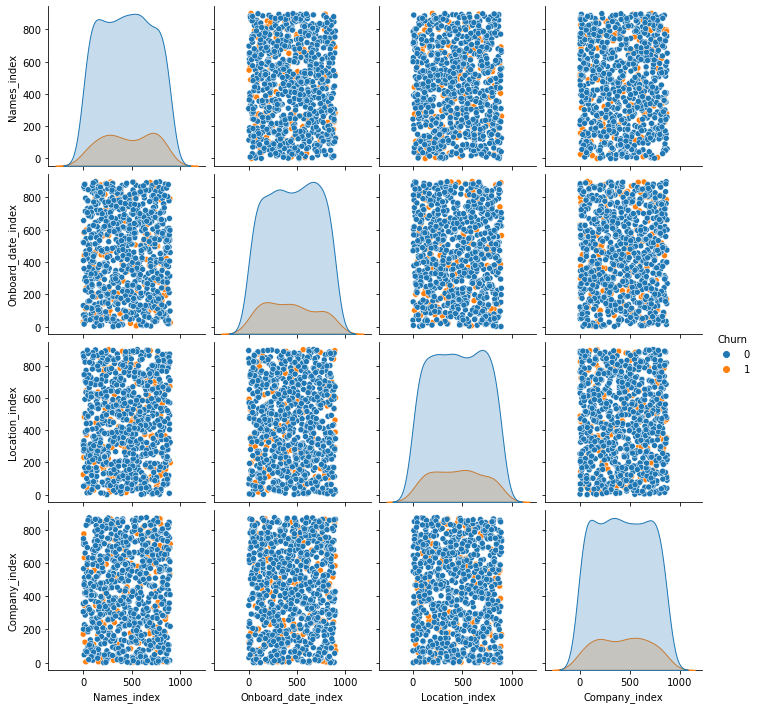

In [11]:
pdf_to_viz = data.select(categorical_column_index+['Churn']).toPandas()
pdf_total = data.toPandas()
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(pdf_to_viz, diag_kind='kde', hue = 'Churn')
plt.show()

In [12]:
# it seems a littlebit relevant!!

# 3. Setting Up DataFrame for Machine Learning 

In [13]:
# A few things we need to do before Spark can accept the data!
# It needs to be in the form of two columns
# ("label","features")

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [14]:
data.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn',
 'Names_index',
 'Onboard_date_index',
 'Location_index',
 'Company_index']

In [15]:
assembler = VectorAssembler(
    inputCols=["Age", "Total_Purchase", 
               "Account_Manager","Years", "Num_Sites", "Names_index", "Onboard_date_index", "Location_index", "Company_index"],
    outputCol="features")

output = assembler.transform(data)

output.select("features", "Churn").show()

+--------------------+-----+
|            features|Churn|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
|[30.0,11575.37,1....|    1|
|[45.0,8771.02,1.0...|    1|
|[45.0,8988.67,1.0...|    1|
|[40.0,8283.32,1.0...|    1|
|[41.0,6569.87,1.0...|    1|
|[38.0,10494.82,1....|    1|
|[45.0,8213.41,1.0...|    1|
|[43.0,11226.88,0....|    1|
|[53.0,5515.09,0.0...|    1|
|[46.0,8046.4,1.0,...|    1|
+--------------------+-----+
only showing top 20 rows



In [16]:
# now that we have the features and the target the final data is
# Renaming "churn" as "label"
output = output.withColumnRenamed("Churn", "label")
final_data = output.select("features", "label")

# 4. Training then testing

>- For this case the training data set will be all our curret dataframe
>- For the testing we will use new_customers.csv

#### Training

In [17]:
training = final_data

lr = LogisticRegression()

# Fit the model
lrModel = lr.fit(training)

trainingSummary = lrModel.summary

In [18]:
trainingSummary.predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[42.0,11066.8,0.0...|  1.0|[2.65525541984728...|[0.93433416759209...|       0.0|
|[41.0,11916.22,0....|  1.0|[-0.5174361218703...|[0.37345194931735...|       1.0|
|[38.0,12884.75,0....|  1.0|[-1.6808182548150...|[0.15698714885985...|       1.0|
|[42.0,8010.76,0.0...|  1.0|[0.70022873535967...|[0.66823848379086...|       0.0|
|[37.0,9191.58,0.0...|  1.0|[2.72807989897014...|[0.93866338151124...|       0.0|
|[48.0,10356.02,0....|  1.0|[3.47910453001924...|[0.97008734648528...|       0.0|
|[44.0,11331.58,1....|  1.0|[-0.4688026941368...|[0.38489966897051...|       1.0|
|[32.0,9885.12,1.0...|  1.0|[1.76251044518146...|[0.85352379700933...|       0.0|
|[43.0,14062.6,1.0...|  1.0|[-0.6746714565711...|[0.33745161399668...|       1.0|
|[40.0,8066.94,1

#### Evaluation

In [19]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [20]:
lrModel.evaluate(training)

In [21]:
predictionAndLabels = lrModel.evaluate(training)

In [22]:
predictionAndLabels.predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[42.0,11066.8,0.0...|    1|[2.65525541984728...|[0.93433416759209...|       0.0|
|[41.0,11916.22,0....|    1|[-0.5174361218703...|[0.37345194931735...|       1.0|
|[38.0,12884.75,0....|    1|[-1.6808182548150...|[0.15698714885985...|       1.0|
|[42.0,8010.76,0.0...|    1|[0.70022873535967...|[0.66823848379086...|       0.0|
|[37.0,9191.58,0.0...|    1|[2.72807989897014...|[0.93866338151124...|       0.0|
|[48.0,10356.02,0....|    1|[3.47910453001924...|[0.97008734648528...|       0.0|
|[44.0,11331.58,1....|    1|[-0.4688026941368...|[0.38489966897051...|       1.0|
|[32.0,9885.12,1.0...|    1|[1.76251044518146...|[0.85352379700933...|       0.0|
|[43.0,14062.6,1.0...|    1|[-0.6746714565711...|[0.33745161399668...|       1.0|
|[40.0,8066.94,1

In [23]:
predictionAndLabels = predictionAndLabels.predictions.select('label','prediction')
predictionAndLabels.show()

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 20 rows



##### What is the accuracy??

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')
acc = evaluator.evaluate(predictionAndLabels)

In [25]:
acc

0.7673333333333333

> Our model is not 100% accurate!! We can increase this accuracy later 

#### Testing

In [38]:
# Loading test dataset and preprocessing it ( creating features)
testing = spark.read.csv("new_customers.csv", header=True, inferSchema=True)

# converting categorical
indexer_test = StringIndexer(inputCols= categorical_column, outputCols=categorical_column_index)
indexed_test = indexer_test.fit(testing).transform(testing)
testing = indexed_test
assembler_test = VectorAssembler(
    inputCols=["Age", "Total_Purchase", 
               "Account_Manager","Years", "Num_Sites", "Names_index", "Onboard_date_index", "Location_index", "Company_index"],
    outputCol="features")

output_test = assembler_test.transform(testing)


testing = output_test

In [39]:
predictions = lrModel.transform(testing.select("features"))


In [40]:
testing.select('Names','features').show()

+--------------+--------------------+
|         Names|            features|
+--------------+--------------------+
| Andrew Mccall|[37.0,9935.53,1.0...|
|Michele Wright|[23.0,7526.94,1.0...|
|  Jeremy Chang|[65.0,100.0,1.0,1...|
|Megan Ferguson|[32.0,6487.5,0.0,...|
|  Taylor Young|[32.0,13147.71,1....|
| Jessica Drake|[22.0,8445.26,1.0...|
+--------------+--------------------+



In [41]:
predictions.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[37.0,9935.53,1.0...|[2.18662690093547...|[0.89904215772760...|       0.0|
|[23.0,7526.94,1.0...|[-6.2608459019759...|[0.00190599001839...|       1.0|
|[65.0,100.0,1.0,1...|[-3.8128510184174...|[0.02160791063290...|       1.0|
|[32.0,6487.5,0.0,...|[-5.1286756281796...|[0.00588950957194...|       1.0|
|[32.0,13147.71,1....|[1.07442150670005...|[0.74543685439078...|       0.0|
|[22.0,8445.26,1.0...|[-1.7263979828191...|[0.15104889733415...|       1.0|
+--------------------+--------------------+--------------------+----------+



>- Andrew Mc call and Taylor Young will Churn according our prediction
>- the other won't churn according our model